# Data Science Assignment 3
## Group 6: Gabriea Groenewegen Van Der Weijden & Arnaud Haaster

### Week 10 preperation:
1. Download the data from https://www.kaggle.com/c/home-depot-product-searchrelevance/data and unzip all files. You now have a directory with four csv files and one docx
file.
2. Import the csv files in Python as separate Pandas dataframes.
3. Read the information on the task and the data. Provide a task definition in your report for
assignment 3

In [37]:
# Importing all necessary packages.

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

In [39]:
# Reading the csv files into dataframes.
df_test = pd.read_csv("test.csv", encoding="ISO-8859-1")
df_train = pd.read_csv("train.csv", encoding="ISO-8859-1")
df_attr = pd.read_csv("attributes.csv")
df_sample_sub = pd.read_csv("sample_submission.csv")
df_pro_desc = pd.read_csv("product_descriptions.csv")


#### Data exploration

In [44]:
# Creating a dataframe with all the product-query combinations.
df_proidq = df_train[["product_uid", "search_term"]]

# Creating a dataframe with all the unique product-query combinations.
un_comb = df_proidq.groupby(["product_uid", "search_term"]).size().reset_index().rename(columns={0: "Occurences"})

# Calculating the unique number of products in the training data.
uni_prod = df_train['product_uid'].nunique()

# Calculating the two most occuring products in the training data.
two_most = df_train.groupby("product_uid").size().reset_index().rename(columns={0: "Occurences"}).sort_values(by=["Occurences"], ascending=False).head(2)

# Calculating the descriptive statistics for the relevance values (mean, median,standard deviation) in the training data.
mean_relevance = round(df_train['relevance'].mean(), 2)
median_relevance = round(df_train['relevance'].median(), 2)
std_relevance = round(df_train['relevance'].std(), 2)

# Preparing the data in order to show a histogram or boxplot of the distribution of relevance values in the training data.
df_rel_val = df_train.groupby("relevance").size().reset_index().rename(columns={0: "Occurences"})

# Calculating the top-5 most occurring brand names in the product attributes?
df_brand_name = df_attr.loc[df_attr["name"] == "MFG Brand Name"].rename(columns={"value":"Brand Name"})
df_name_atr = df_brand_name.groupby("Brand Name").size().reset_index().rename(columns={0: "Occurences"}).sort_values(by =["Occurences"], ascending=False).head(6)

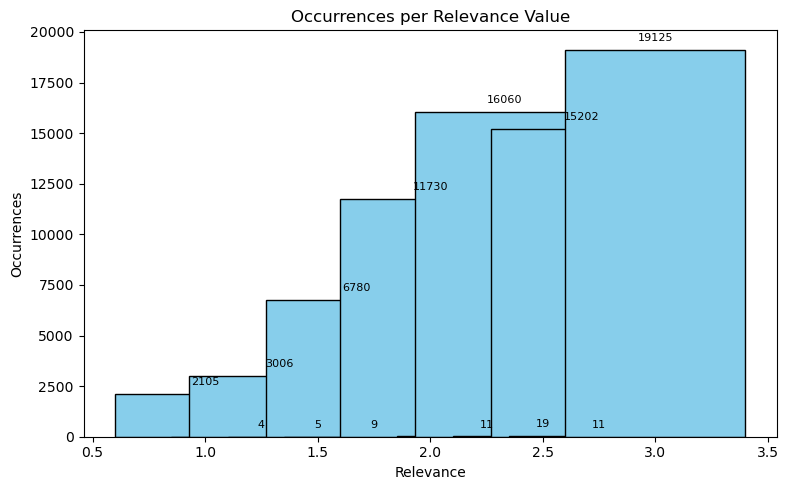

In [11]:
x_val = df_rel_val["relevance"]
y_val = df_rel_val["Occurences"]

# Sort data by relevance
data_sorted = df_rel_val.sort_values("relevance")
x_sorted = data_sorted["relevance"].tolist()
y_sorted = data_sorted["Occurences"].tolist()

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(x_sorted, y_sorted, color='skyblue', edgecolor='black')

ax.set_ylabel('Occurrences')
ax.set_xlabel('Relevance')
ax.set_title('Occurrences per Relevance Value')

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



In [52]:
# The copy of the model.

stemmer = SnowballStemmer('english')
num_train = df_train.shape[0]

def str_stemmer(s):
	return " ".join([stemmer.stem(word) for word in s.lower().split()])

def str_common_word(str1, str2):
	return sum(int(str2.find(word)>=0) for word in str1.split())


df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

df_all = pd.merge(df_all, df_pro_desc, how='left', on='product_uid')

df_all['search_term'] = df_all['search_term'].map(lambda x:str_stemmer(x))
df_all['product_title'] = df_all['product_title'].map(lambda x:str_stemmer(x))
df_all['product_description'] = df_all['product_description'].map(lambda x:str_stemmer(x))

df_all['len_of_query'] = df_all['search_term'].map(lambda x:len(x.split())).astype(np.int64)

df_all['product_info'] = df_all['search_term']+"\t"+df_all['product_title']+"\t"+df_all['product_description']

df_all['word_in_title'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[1]))
df_all['word_in_description'] = df_all['product_info'].map(lambda x:str_common_word(x.split('\t')[0],x.split('\t')[2]))

# Ben's addition.
# df_all['similarity'] = df_all['product_info'].map(lambda x: word_similarity(x.split('\t')))

df_all = df_all.drop(['search_term','product_title','product_description','product_info'],axis=1)

df_train_stem = df_all.iloc[:num_train]
df_test_stem = df_all.iloc[num_train:]
id_test_stem = df_test['id']

y_train = df_train_stem['relevance'].values
X_train = df_train_stem .drop(['id','relevance'],axis=1).values
X_test = df_test_stem.drop(['id','relevance'],axis=1).values

rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

pd.DataFrame({"id": id_test_stem, "relevance": y_pred}).to_csv('submission.csv',index=False)


### Week 11
1. Make a 80-20 split of the training set, using 80% for training and 20% for testing using the
train_test_split function in sklearn.
2. Evaluate the predictions on the test set in terms of Root Mean Squared Error (RMSE). Verify
that your result is close to 0.48. 

The obtained result is your baseline result. Make sure that you use the same train-test split in every
run. Be aware that lower RMSE scores are better.

3. Evaluate the matching without stemming for search terms, product titles, and product
descriptions.

#### Evaluation

In [13]:
# Splitting the train data into 80% of training and 20% testing.

# We are trying to predict the relevance of the tools.
X = df_train_stem.drop(columns=['relevance', 'id', 'product_uid'])
y = df_train_stem['relevance']

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)


""" Evaluating the predictions on the test set in terms of Root mean squared error. """

# Fitting the model.
clf.fit(X_train, y_train)

# Predictions on the test set.
y_pred_clf = clf.predict(X_test)
rmse_clf = np.sqrt(mean_squared_error(y_test, y_pred_clf))

print("Root Mean Squared Error (RMSE) for clf:", round(rmse_clf, 4))

Root Mean Squared Error (RMSE) for clf: 0.4849


In [14]:
# Re-reading the csv files into dataframes because the previous ones have been changed.
df_test = pd.read_csv("test.csv", encoding="ISO-8859-1")
df_train = pd.read_csv("train.csv", encoding="ISO-8859-1")
df_attr = pd.read_csv("attributes.csv")
df_sample_sub = pd.read_csv("sample_submission.csv")
df_pro_desc = pd.read_csv("product_descriptions.csv")

In [15]:
# Evaluating the matching without stemming for search terms, product titles, and product descriptions.

# Rebuild from original inputs
df_all_nostem = pd.concat((df_train, df_test), axis=0, ignore_index=True)
df_all_nostem = pd.merge(df_all_nostem, df_pro_desc, how='left', on='product_uid')

# Lowercasing only (no stemming)
df_all_nostem['search_term'] = df_all_nostem['search_term'].map(lambda x: x.lower())
df_all_nostem['product_title'] = df_all_nostem['product_title'].map(lambda x: x.lower())
df_all_nostem['product_description'] = df_all_nostem['product_description'].map(lambda x: x.lower())

# Feature engineering
df_all_nostem['len_of_query'] = df_all_nostem['search_term'].map(lambda x: len(x.split())).astype(np.int64)
df_all_nostem['product_info'] = df_all_nostem['search_term'] + "\t" + df_all_nostem['product_title'] + "\t" + df_all_nostem['product_description']

def str_common_word(str1, str2):
    return sum(int(str2.find(word) >= 0) for word in str1.split())

df_all_nostem['word_in_title'] = df_all_nostem['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[1]))
df_all_nostem['word_in_description'] = df_all_nostem['product_info'].map(lambda x: str_common_word(x.split('\t')[0], x.split('\t')[2]))


# Drop intermediate text columns
df_all_nostem = df_all_nostem.drop(['search_term', 'product_title', 'product_description', 'product_info'], axis=1)

# Split
df_train_nostem = df_all_nostem.iloc[:num_train]
df_test_nostem = df_all_nostem.iloc[num_train:]
id_test = df_test_nostem['id']

y_train = df_train_nostem['relevance'].values
X_train = df_train_nostem.drop(['id', 'relevance'], axis=1).values
X_test = df_test_nostem.drop(['id', 'relevance'], axis=1).values

# Train and predict
rf = RandomForestRegressor(n_estimators=15, max_depth=6, random_state=0)
clf = BaggingRegressor(rf, n_estimators=45, max_samples=0.1, random_state=25)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Save result
pd.DataFrame({"id": id_test, "relevance": y_pred}).to_csv('submission_no_stemming.csv', index=False)


In [16]:
# We are trying to predict the relevance of the tools.
X = df_train_nostem.drop(columns=['relevance', 'id', 'product_uid'])
y = df_train_nostem['relevance']

# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)

""" Evaluating the predictions on the test set in terms of Root mean squared error. """

# Fitting the models
clf.fit(X_train, y_train)

# 2. Predict on the test set
y_pred_clf = clf.predict(X_test)

# 3. Compute RMSE
rmse_clf = np.sqrt(mean_squared_error(y_test, y_pred_clf))
print("Root Mean Squared Error (RMSE) for clf without stemming:", round(rmse_clf, 4))

Root Mean Squared Error (RMSE) for clf without stemming: 0.4949


#### Improving the matching


Add features for the query-product matching and evaluate the efficacy of each feature. A few
suggestions are:
• Add features for matching query terms to the information in attributes.csv
• Use the structure of the attribute-value pairs to make better informed features
• Replace the simple term count matching functions with other overlap weights. You might
consider using the function TfidfVectorizer in sklearn or the text similarity function in the
spacy package.
Be creative: use any information from the queries and products that might improve the matching

In [17]:
# Add feature for seart term and name similarity.
nlp = spacy.load("en_core_web_sm")
s1 = nlp("Hello World!")
s2 = nlp("Goodbye world")
s1.similarity(s2)

/var/folders/bt/y4y1_vy108q8105yqndh1pbm0000gn/T/ipykernel_49737/2536976382.py:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  s1.similarity(s2)


0.4350014328956604

In [46]:
df_train

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67
...,...,...,...,...,...
74062,221457,206638,Atlantic Windowpane 576 CD or 192 DVD Blu-Ray ...,tv riser glass,1.00
74063,221458,206639,Philips 40-Watt Halogen R20 Flood Light Bulb (...,r20 halogen light,3.00
74064,221463,206641,Schlage Camelot In-Active Aged Bronze Handlese...,schlage lock siena half dummy knob with,2.33
74065,221471,206648,Plastec 11 in. x 24 in. Rose Garden Wall Decor...,zen garden decor,3.00


In [79]:
df_proq = df_train[["product_title", "search_term"]]
df_proq = nlp(df_proq["product_title"])
# for idx, row in df_proq.iterrows():
#     s1 = nlp(row[0])
#     s2 = nlp(row[1])
# nlp(df_proq["product_title"].values.tolist())
# df_proq["Similarity"] = (df_proq["product_title"].values.tolist().similarity(df_proq["search_term"].values.tolist()))

ValueError: [E1041] Expected a string, Doc, or bytes as input, but got: <class 'pandas.core.series.Series'>

In [51]:
for idx, row in df_proq.iterrows():
    s1 = nlp(row[0])
    s2 = nlp(row[1])

/var/folders/bt/y4y1_vy108q8105yqndh1pbm0000gn/T/ipykernel_49737/3478340840.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(row[0], row[1])


Simpson Strong-Tie 12-Gauge Angle angle bracket
Simpson Strong-Tie 12-Gauge Angle l bracket
BEHR Premium Textured DeckOver 1-gal. #SC-141 Tugboat Wood and Concrete Coating deck over
Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included) rain shower head
Delta Vero 1-Handle Shower Only Faucet Trim Kit in Chrome (Valve Not Included) shower only faucet
Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking convection otr
Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking microwave over stove
Whirlpool 1.9 cu. ft. Over the Range Convection Microwave in Stainless Steel with Sensor Cooking microwaves
Lithonia Lighting Quantum 2-Light Black LED Emergency Fixture Unit emergency light
House of Fara 3/4 in. x 3 in. x 8 ft. MDF Fluted Casing mdf 3/4
Valley View Industries Metal Stakes (4-Pack) steele stake
Toro Personal Pace Recycler 22 in. Variable Speed Self-Propelled Gas Lawn Mower w

KeyboardInterrupt: 

### Week 12
1. Find three other regression models in the sklearn documentation and compare these for the task,
both in quality (RMSE) and processing time. A comparison of the results for four regression models are part of the report for assignment 3.
2. Select the model that works the best. You will now optimize the model’s hyperparameters. In Sklearn
there are some very simple hyper parameter tuning methods: https://scikitlearn.org/stable/modules/grid_search.html . It is also possible to use more advanced methods such
as Bayesian Optimization (https://github.com/wangronin/Bayesian-Optimization/ ).
Make sure you are not optimizing on your test set; you will need to use cross validation on the train
set (e.g using the function RandomizedSearchCV)
3. 